In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

# Set style for the plots
plt.style.use('seaborn-v0_8')

In [2]:
df_lvl = pd.read_csv("../data/processed/water_levels_daily.csv", parse_dates=["timestamp"])
daily_levels = (
    df_lvl.set_index("timestamp")["value"]
           .resample("D").mean()
           .interpolate()                       # close tiny gaps if any
)

daily_df = daily_levels.to_frame(name="water_level")

doy     = daily_df.index.dayofyear
ang_yr  = 2 * np.pi * doy / 365.25
dow     = daily_df.index.dayofweek
ang_wk  = 2 * np.pi * dow / 7

daily_df["sin365"] = np.sin(ang_yr)
daily_df["cos365"] = np.cos(ang_yr)
daily_df["sin365_2"] = np.sin(2*ang_yr)
daily_df["cos365_2"] = np.cos(2*ang_yr)


weather_raw = (
    pd.read_csv(
        "../data/raw/edersee_historical_weather.csv",
        skiprows=3,                       # first 2 meta lines + blank line
        parse_dates=["time"],
    )
    .rename(columns={"time": "timestamp"})
)

weather = (
    weather_raw
      .set_index("timestamp")
      .sort_index()
      .resample("D").mean()
      .interpolate(limit=7)               # close small gaps
)

# Drop weather_code column
weather.drop(columns=["weather_code (wmo code)"], inplace=True)


anchor_template = [
    ("11-01", 237.30),  # 1 Nov
    ("12-15", 237.30),
    ("01-01", 239.61),
    ("02-01", 241.71),
    ("03-01", 242.70),
    ("04-01", 244.10),
    ("05-01", 244.95),  # 1 May
]

def compute_max_level_series(dates: pd.DatetimeIndex) -> pd.Series:
    def cap_on(day: pd.Timestamp) -> float:
        year0 = day.year if day.month >= 11 else day.year - 1
        pts   = []
        for mm_dd, lvl in anchor_template:
            mm, dd = map(int, mm_dd.split("-"))
            yr     = year0 if mm >= 11 else year0 + 1
            try:
                pts.append((pd.Timestamp(yr, mm, dd), lvl))
            except ValueError:  # 29 Feb on non-leap
                pts.append((pd.Timestamp(yr, 2, 28), lvl))
        pts.sort(key=lambda x: x[0])
        if day < pts[0][0] or day >= pts[-1][0]:
            return pts[-1][1]
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= day <= d1:
                frac = (day - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        return pts[-1][1]

    return pd.Series([cap_on(d) for d in dates], index=dates, name="max_level_m")

max_level = compute_max_level_series(daily_df.index)

daily_df["max_level_m"] = max_level

df = pd.merge(
    daily_df,
    weather,
    left_index=True,
    right_index=True,
    how="left",
)

df.to_csv("../data/processed/water_levels_weather.csv", index=True)

In [3]:
# ---------- Load data ----------
file_path = '../data/processed/water_levels_weather.csv'
df = pd.read_csv(file_path, parse_dates=['timestamp'])

# ---------- Feature engineering ----------
# Target: water level 28 days ahead
HORIZON = 28  # days
df['target'] = df['water_level'].shift(-HORIZON)

df["pred_date"] = df["timestamp"] + pd.Timedelta(days=HORIZON)

# Lag features of water level
lag_days = [1, 2, 3, 7, 14, 21, 365]  # 1 year = 365 days, 2 years = 730 days
for l in lag_days:
    df[f'lag_{l}'] = df['water_level'].shift(l)

# Rolling statistics of water level (exclude current day to prevent leakage)
roll_windows = [7, 14, 28]
for w in roll_windows:
    df[f'rolling_mean_{w}'] = df['water_level'].shift(1).rolling(window=w).mean()
    df[f'rolling_std_{w}'] = df['water_level'].shift(1).rolling(window=w).std()
    
for k in [1,3,7]:
    df[f"delta_{k}"] = df["water_level"].diff(k)

    
# for w in [3,7]:
#     df[f"precip_sum_{w}"] = weather["precipitation_sum (mm)"].rolling(w).sum()
#     df[f"temp_mean_{w}"]  = weather["temperature_2m_mean (°C)"].rolling(w).mean()

# Month to capture intra‑annual seasonality (already have sin/cos, but add raw DOY as well)
df['month'] = df['timestamp'].dt.month

# Drop any rows with NaNs introduced by shifting/rolling
df = df.dropna().reset_index(drop=True)

df.head()

,timestamp,water_level,sin365,cos365,sin365_2,cos365_2,max_level_m,snowfall_sum (cm),precipitation_sum (mm),precipitation_hours (h),...,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,delta_1,delta_3,delta_7,month
0,2000-12-31,237.09,0.012901,0.999917,0.025801,0.999667,239.474118,0.0,0.0,0.0,...,237.205714,0.041975,236.980000,0.385247,235.557500,1.553895,-0.04,-0.11,-0.14,12
1,2001-01-01,237.03,0.017202,0.999852,0.034398,0.999408,239.610000,0.0,4.9,13.0,...,237.185714,0.058554,237.055714,0.271569,235.688571,1.521361,-0.06,-0.14,-0.21,1
2,2001-01-02,236.98,0.034398,0.999408,0.068755,0.997634,239.677742,0.0,1.5,5.0,...,237.155714,0.076997,237.105714,0.174916,235.816786,1.475423,-0.05,-0.15,-0.26,1
3,2001-01-03,236.98,0.051584,0.998669,0.103031,0.994678,239.745484,0.0,0.5,3.0,...,237.118571,0.091000,237.130714,0.117176,235.939286,1.421660,0.00,-0.11,-0.25,1
4,2001-01-04,237.14,0.068755,0.997634,0.137185,0.990545,239.813226,0.0,1.5,9.0,...,237.082857,0.089016,237.140000,0.096556,236.058929,1.359734,0.16,0.11,-0.06,1


In [4]:
# ---------- Train / validation split ----------
train_end = pd.Timestamp("2017-12-31")
val_end   = pd.Timestamp("2020-12-31")

# Split by pred_date, not timestamp
train_df = df[df["pred_date"] <= train_end]
val_df   = df[(df["pred_date"] > train_end) & (df["pred_date"] <= val_end)]
test_df  = df[df["pred_date"] > val_end]           # keep for later

# Keep only rows that still have a target
train_df = train_df.dropna(subset=["target"])
val_df   = val_df.dropna(subset=["target"])
test_df  = test_df.dropna(subset=["target"])

# Build features/labels
exceptions = ["timestamp", "pred_date", "target",
              'precipitation_sum (mm)', 'snowfall_sum (cm)']
feature_cols = [c for c in train_df.columns if c not in
                exceptions]

X_train, y_train = train_df[feature_cols], train_df["target"]
X_val,   y_val   = val_df[feature_cols],   val_df["target"]
X_test,  y_test  = test_df[feature_cols],  test_df["target"]

In [ ]:
# ---------- Optuna hyperparameter tuning ----------
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse', # Use RMSE for optimization metric
        'booster': 'gbtree',
        'n_jobs': -1,
        'random_state': 26,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1),
        'gamma': trial.suggest_float('gamma', 0, 1.0, step=0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 5.0, log=True),
    }

    # Using the constructor argument that worked for you
    model = xgb.XGBRegressor(**params, n_estimators=2000, early_stopping_rounds=50)

    # Fit without early_stopping_rounds here, as it's in the constructor now
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)

    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

# --- Optuna Study with Progress Bar ---

n_trials = 100 # Define number of trials

# Create a study object
study = optuna.create_study(direction='minimize') # Minimize RMSE

# Create the tqdm progress bar context
with tqdm(total=n_trials, desc="Optimizing Hyperparameters") as pbar:
    # Define the callback function to update the progress bar
    def tqdm_callback(study, trial):
        pbar.update(1)

    # Run optimization with the callback
    study.optimize(
        objective,
        n_trials=n_trials,
        callbacks=[tqdm_callback] # Pass the callback function here
    )
    # The progress bar will be automatically closed by the 'with' statement

# --- Print results and train final model ---
print("Best trial:")
best_trial = study.best_trial # Use best_trial attribute
print(f"  Value (RMSE): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Train the final model with the best parameters
best_params = best_trial.params

In [5]:
# Best parameters found by Optuna
best_params_from_optuna = {
    'learning_rate': 0.011000063748620762,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'gamma': 0.2,
    'reg_alpha': 0.1883710504748341,
    'reg_lambda': 1.1406910783458322e-05
}

# Define the model using the best parameters
model = xgb.XGBRegressor(
    **best_params_from_optuna,
    objective='reg:squarederror',
    n_estimators=2000,  # Set high enough (e.g., 2000 used in HPO)
    random_state=26,
    n_jobs=-1,
    early_stopping_rounds=50
)

# Define the evaluation set for early stopping
eval_set = [(X_val, y_val)]

# Train the model using early stopping within the fit method
print("Fitting model with optimized parameters...")
model.fit(X_train, y_train,
          eval_set=eval_set,
          verbose=100) # Print evaluation metric every 100 rounds

Fitting model with optimized parameters...
[0]	validation_0-rmse:10.67045
[100]	validation_0-rmse:4.41762
[200]	validation_0-rmse:2.42506
[300]	validation_0-rmse:1.86488
[400]	validation_0-rmse:1.71490
[500]	validation_0-rmse:1.65640
[600]	validation_0-rmse:1.63639
[700]	validation_0-rmse:1.62342
[800]	validation_0-rmse:1.61615
[900]	validation_0-rmse:1.61090
[949]	validation_0-rmse:1.61364


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.2, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.011000063748620762, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=-1,
             num_parallel_tree=None, ...)

--------------------------------------------------
Validation MAE  : 1.2668 m
Validation RMSE : 1.6108 m
--------------------------------------------------


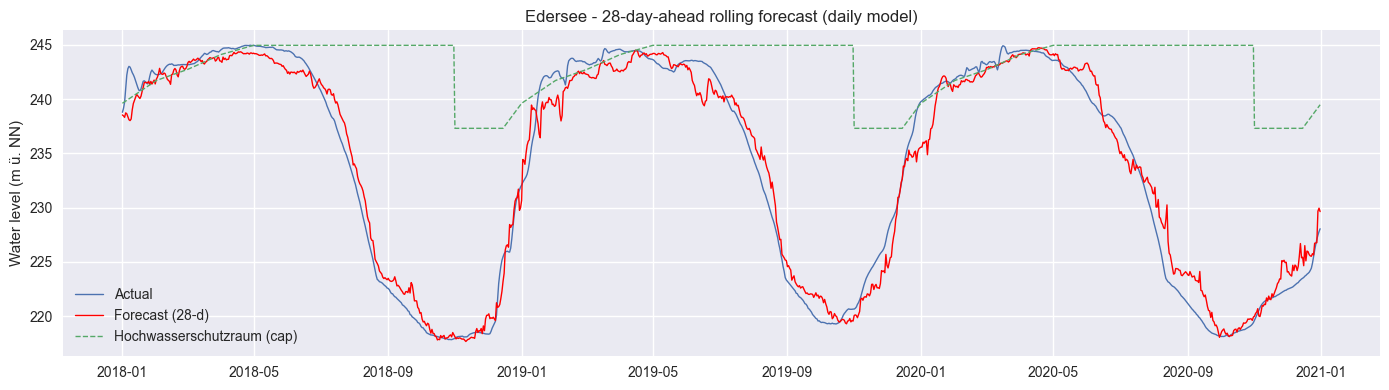

In [ ]:
# --------------------------------------------------
# 8. Validation metrics
# --------------------------------------------------
val_pred = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, val_pred))
mae  = mean_absolute_error(y_val, val_pred)

print("Validation results")
print("-" * 50)
print(f"Validation MAE  : {mae:6.4f} m")
print(f"Validation RMSE : {rmse:6.4f} m")
print("-" * 50)

# (optional) Feature importance:
# importances = model.get_booster().get_score(importance_type="gain")

# --------------------------------------------------
# 9. Quick plot
# --------------------------------------------------
plot_dates = val_df["pred_date"]                  # already T+28
dyn_cap    = compute_max_level_series(plot_dates).values

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(plot_dates, y_val,     label="Actual",          lw=1)
ax.plot(plot_dates, val_pred,  label="Forecast (28-d)", lw=1, color="red")
ax.plot(plot_dates, dyn_cap,   label="Hochwasserschutzraum (cap)",
                               ls="--", lw=1)
ax.set_ylabel("Water level (m ü. NN)")
ax.set_title("Edersee - 28-day-ahead rolling forecast (daily model)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Save predictions to CSV
predictions_df = pd.DataFrame({
    "Actual"   : np.array(y_val),
    "Predicted": val_pred,
}, index=plot_dates)
predictions_df.to_csv("../output/predictions/XGBoost_predictions.csv", index=True)

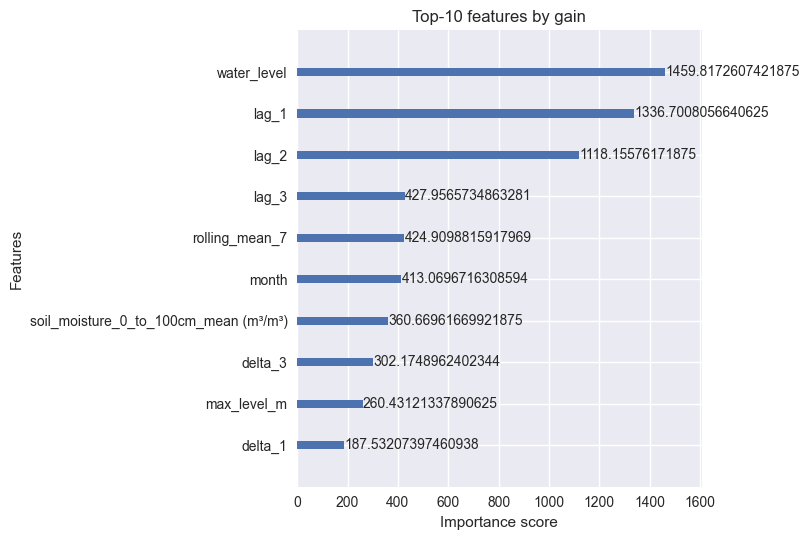

In [ ]:
from xgboost import plot_importance

# make sure `model` is already fitted
plot_importance(
    model,                       # the fitted XGBRegressor
    max_num_features=10,         # top‑20
    importance_type="gain"       # average loss‑reduction brought by splits
)
plt.title("Top-10 features by gain")
plt.tight_layout()
plt.show()

In [ ]:
booster = model.get_booster()                     # same fitted model
gain    = booster.get_score(importance_type="gain")
weight  = booster.get_score(importance_type="weight")

imp_df = (pd.Series(gain, name="gain")
            .to_frame()
            .assign(weight=lambda d: d.index.map(weight).fillna(0).astype(int))
            .sort_values("gain", ascending=False))

imp_df.head(10)

,gain,weight
water_level,1459.817261,3433
lag_1,1336.700806,1162
lag_2,1118.155762,833
lag_3,427.956573,594
rolling_mean_7,424.909882,630
month,413.069672,364
soil_moisture_0_to_100cm_mean (m³/m³),360.669617,3177
delta_3,302.174896,905
max_level_m,260.431213,439
delta_1,187.532074,1025


Test results
--------------------------------------------------
Test MAE  : 1.9848 m
Test RMSE : 2.8724 m
--------------------------------------------------


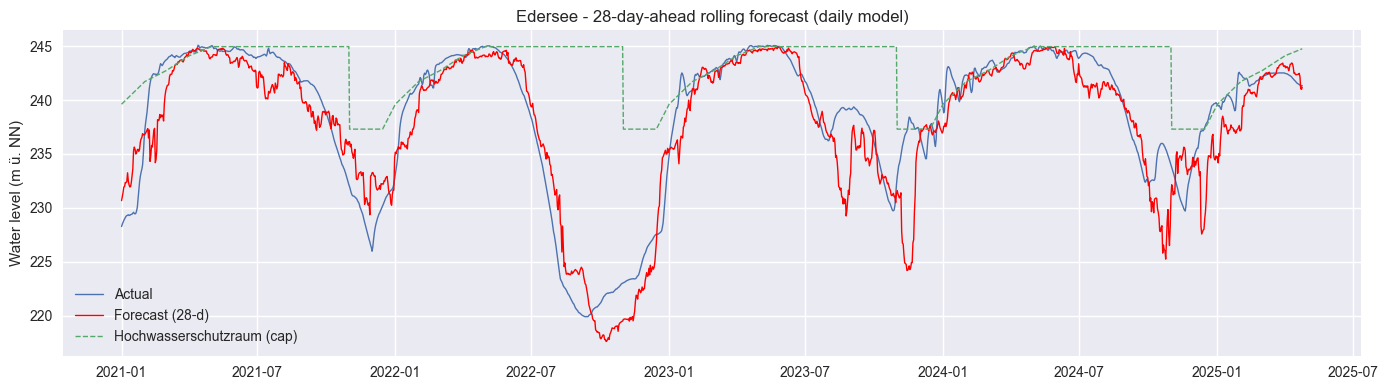

In [8]:
# --------------------------------------------------
# 8. Validation metrics
# --------------------------------------------------
test_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, test_pred))
mae  = mean_absolute_error(y_test, test_pred)

print("Test results")
print("-" * 50)
print(f"Test MAE  : {mae:6.4f} m")
print(f"Test RMSE : {rmse:6.4f} m")
print("-" * 50)

# (optional) Feature importance:
# importances = model.get_booster().get_score(importance_type="gain")

# --------------------------------------------------
# 9. Quick plot
# --------------------------------------------------
plot_dates = test_df["pred_date"]                  # already T+28
dyn_cap    = compute_max_level_series(plot_dates).values

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(plot_dates, y_test,     label="Actual",          lw=1)
ax.plot(plot_dates, test_pred,  label="Forecast (28-d)", lw=1, color="red")
ax.plot(plot_dates, dyn_cap,   label="Hochwasserschutzraum (cap)",
                               ls="--", lw=1)
ax.set_ylabel("Water level (m ü. NN)")
ax.set_title("Edersee - 28-day-ahead rolling forecast (daily model)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Save predictions to CSV
predictions_df = pd.DataFrame({
    "Actual"   : np.array(y_test),
    "Predicted": test_pred,
}, index=plot_dates)
predictions_df.to_csv("../output/predictions/XGBoost_test_predictions.csv", index=True)